In [3]:
from IPython import get_ipython
from IPython.display import display
# Import libraries for data processing, modeling, and visualization
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence # Import the Sequence class


!pip install tensorflow numpy scikit-learn


In [4]:
# Limit GPU memory growth to prevent fragmentation
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# Read the dataset from a text file
with open('/content/sample_data/LSTM DATA.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [6]:
# Convert text to lowercase for consistency
text = text.lower()

In [7]:
# Tokenize the text into words with limited vocabulary
max_words = 10000  # Limit vocabulary size to reduce memory
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts([text])
total_words = min(len(tokenizer.word_index) + 1, max_words)

In [14]:
# Create a data generator to handle sequences efficiently
class SequenceGenerator(Sequence):
    # Initialize generator with text, tokenizer, and parameters
    def __init__(self, text, tokenizer, max_sequence_len, batch_size):
        self.text = text
        self.tokenizer = tokenizer
        self.max_sequence_len = max_sequence_len
        self.batch_size = batch_size
        self.lines = [line for line in text.split('\n') if line.strip()]
        self.indices = []
        for line_idx, line in enumerate(self.lines):
            token_list = tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                # This condition 'self.indices is None' will always be false
                # since self.indices is initialized as an empty list [].
                # The condition should be removed or corrected based on intent.
                # Assuming the intent is to append all valid indices:
                self.indices.append((line_idx, i))

    # Return number of batches
    def __len__(self):
        return len(self.indices) // self.batch_size

        # Generate a batch of data
    def __getitem__(self, index):
        # Use the correct variable name for slicing: index instead of i
        batch_indices = self.indices[index * self.batch_size:(index+1) * self.batch_size]
        X = []
        y = []
        for line_idx, seq_idx in batch_indices:
            token_list = self.tokenizer.texts_to_sequences([self.lines[line_idx]])[0]
            n_gram_sequence = token_list[max(0, seq_idx-self.max_sequence_len):seq_idx]
            X.append(pad_sequences([n_gram_sequence], maxlen=self.max_sequence_len, padding='pre')[0])
            y.append(token_list[seq_idx])
        X = np.array(X)
        y = tf.keras.utils.to_categorical(y, num_classes=total_words)
        return X, y

In [15]:
# Set parameters for reduced memory usage
max_sequence_len = 20  # Reduced sequence length
batch_size = 32       # Reduced batch size
train_generator = SequenceGenerator(text, tokenizer, max_sequence_len, batch_size)
val_generator = SequenceGenerator(text, tokenizer, max_sequence_len, batch_size)

In [21]:
from tensorflow.keras.layers import Attention, Flatten, GlobalAveragePooling1D

# Define a smaller LSTM model architecture
model = Sequential([
    # Convert word indices to dense vectors
    Embedding(total_words, 64, input_length=max_sequence_len),  # Single LSTM layer to reduce memory
    LSTM(64, return_sequences=True),
    # Use GlobalAveragePooling1D to pool the sequence dimension
    # This outputs a tensor of shape (batch_size, units) which
    # is suitable for the Dense layer after Dropout.
    GlobalAveragePooling1D(),
    # Dropout to prevent overfitting
    Dropout(0.3),
    # Dense layer with softmax for word prediction
    Dense(total_words, activation='softmax')
])


In [22]:
# Compile the model with loss function and optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Define callbacks for early stopping and learning rate scheduling
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), # Increased patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001) # Adjusted patience
]

In [46]:
# Train the model using the data generator
history = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.1420 - loss: 5.1642 - val_accuracy: 0.1639 - val_loss: 4.9853 - learning_rate: 0.0010
Epoch 2/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.1449 - loss: 5.1242 - val_accuracy: 0.1675 - val_loss: 4.9407 - learning_rate: 0.0010
Epoch 3/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - accuracy: 0.1491 - loss: 5.0792 - val_accuracy: 0.1762 - val_loss: 4.9046 - learning_rate: 0.0010
Epoch 4/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 75s 20ms/step - accuracy: 0.1527 - loss: 5.0481 - val_accuracy: 0.1805 - val_loss: 4.8563 - learning_rate: 0.0010
Epoch 5/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.1571 - loss: 5.0171 - val_accuracy: 0.1858 - val_loss: 4.8233 - learning_rate: 0.0010
Epoch 6/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.1606 - loss: 4.9714 - val_accuracy: 0.1871 - val_loss: 4.7824 - learning_rate: 0.0010
Epoch 7/12
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 55s 14ms/step - accura

In [47]:
# Evaluate the model on a subset of test data
test_generator = SequenceGenerator(text, tokenizer, max_sequence_len, batch_size)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


3784/3784 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.2186 - loss: 4.5931
Test Loss: 4.5758, Test Accuracy: 0.2134


In [48]:
# Calculate perplexity (exp(loss)) as a language model metric
perplexity = np.exp(test_loss)
print(f"Test Perplexity: {perplexity:.4f}")

Test Perplexity: 97.1021


In [49]:
# Function to predict the next word for a given text
def predict_next_word(model, tokenizer, text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list[-max_sequence_len:]], maxlen=max_sequence_len, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=1)[0]
    return [word for word, index in tokenizer.word_index.items() if index == predicted_word_index][0]

In [50]:
# Test next word prediction on a sample text
sample_text = "to be or not to be that is the"
predicted_word = predict_next_word(model, tokenizer, sample_text, max_sequence_len)
print(f"Sample Text: {sample_text}")
print(f"Predicted Next Word: {predicted_word}")

Sample Text: to be or not to be that is the
Predicted Next Word: man


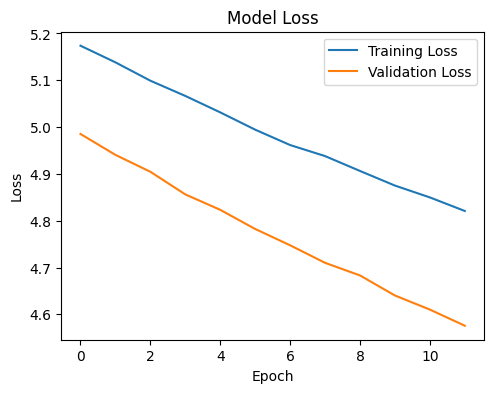

In [51]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

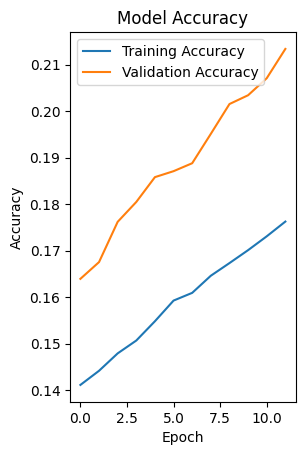

In [52]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
# Fine-tune the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/5
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - accuracy: 0.1862 - loss: 4.7329 - val_accuracy: 0.2182 - val_loss: 4.5489 - learning_rate: 1.0000e-04
Epoch 2/5
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 75s 20ms/step - accuracy: 0.1893 - loss: 4.7084 - val_accuracy: 0.2194 - val_loss: 4.5320 - learning_rate: 1.0000e-04
Epoch 3/5
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.1886 - loss: 4.7049 - val_accuracy: 0.2208 - val_loss: 4.5216 - learning_rate: 1.0000e-04
Epoch 4/5
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.1919 - loss: 4.6893 - val_accuracy: 0.2225 - val_loss: 4.5114 - learning_rate: 1.0000e-04
Epoch 5/5
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.1908 - loss: 4.6888 - val_accuracy: 0.2225 - val_loss: 4.5031 - learning_rate: 1.0000e-04
